# 1- Import libraries



In [ ]:
#Basics libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import random # Import random library
import tensorflow as tf # Import tensorflow library
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Image processing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Deep Learning Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, InputLayer
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

# 2-Data Download


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plant-disease-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/plant-disease-recognition-dataset


In [ ]:
download_path = "/root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1"
train_dir = os.path.join(download_path, "Train", "Train")
val_dir = os.path.join(download_path, "Validation", "Validation")
test_dir = os.path.join(download_path, "Test", "Test")

# 3-Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip= True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# 4-Load Data.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical', seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,seed=SEED
)


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}
3


# 5- Model.

In [ ]:
from typing_extensions import Literal
base_model = VGG19(include_top=False,weights="imagenet",input_shape=(224,224,3))
base_model.trainable = False
for layer in base_model.layers:
  layer.trainable = True
for layer in base_model.layers[:-2]:
  layer.trainable = False

from tensorflow.keras.models import Model
inputs = Input(shape=(224,224,3))
# Chain layers
x = base_model(inputs)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x) # Changed to 3 units for 3 classes
# Define model
transfer_model = Model(inputs, outputs)


transfer_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
print(train_generator.class_mode)
print(val_generator.class_mode)
print(train_generator.num_classes)


categorical
categorical
3


In [ ]:
transfer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,372,419 (176.90 MB)

 Trainable params: 28,707,843 (109.51 MB)

 Non-trainable params: 17,664,576 (67.39 MB)

# 6- Training Model.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True
)

history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30 , callbacks=[early_stop]

)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.3990 - loss: 1.8204 - val_accuracy: 0.7833 - val_loss: 0.5185
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7864 - loss: 0.5545 - val_accuracy: 0.9333 - val_loss: 0.2445
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9180 - loss: 0.2477 - val_accuracy: 0.9167 - val_loss: 0.1515
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9220 - loss: 0.2641 - val_accuracy: 0.9333 - val_loss: 0.1923


# 7- Performance Evaluation

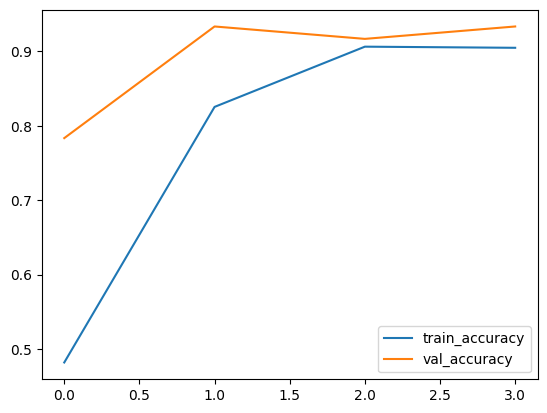

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# 7- Save Model

In [ ]:
transfer_model.save("plant_pathology_model.keras")

# 8-Evaluate the test set

In [ ]:
test_loss, test_acc = transfer_model.evaluate(test_generator)
print("Test accuracy:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9504 - loss: 0.1814
Test accuracy: 0.9266666769981384


In [ ]:

preds = transfer_model.predict(test_generator)
preds

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


array([[9.07821894e-01, 2.63456237e-02, 6.58325180e-02],
       [8.27124476e-01, 9.81496647e-02, 7.47258589e-02],
       [9.21198726e-01, 7.14483671e-03, 7.16564208e-02],
       [8.91543448e-01, 1.97816174e-02, 8.86748880e-02],
       [9.39052224e-01, 9.24373977e-03, 5.17040528e-02],
       [8.12119901e-01, 7.05391020e-02, 1.17341019e-01],
       [9.94998157e-01, 6.60116377e-04, 4.34176577e-03],
       [8.99372756e-01, 1.66997313e-02, 8.39275941e-02],
       [9.84138668e-01, 1.64193381e-03, 1.42193912e-02],
       [9.74166691e-01, 3.41897458e-03, 2.24143714e-02],
       [9.91461515e-01, 2.55532353e-03, 5.98323345e-03],
       [9.90610898e-01, 2.73726997e-03, 6.65174657e-03],
       [9.71933305e-01, 4.05273912e-03, 2.40138676e-02],
       [9.27693367e-01, 9.25485976e-03, 6.30518049e-02],
       [9.67741072e-01, 7.64914136e-03, 2.46097799e-02],
       [9.33754981e-01, 1.25384480e-02, 5.37065789e-02],
       [6.94493532e-01, 2.69027680e-01, 3.64788324e-02],
       [9.92485583e-01, 5.80404

#